In [1]:
from model.model import ConvModel, PreTrainer, show_results, HeadTrainer, HeadTrainerNew
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
    gpu_index = 0
else:
    device = torch.device('cpu')
    gpu_index = -1


In [3]:
device

device(type='cuda')

In [4]:
color_jitter = transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)


composed_transforms = transforms.Compose([
    transforms.RandomApply([color_jitter], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=3),
      transforms.ToTensor()])

In [5]:
train_dataset_1 = datasets.CIFAR10('./datasets',  download=True, train=True, transform=composed_transforms)
train_dataset_2 = datasets.CIFAR10('./datasets', download=True, train=True, transform=transforms.ToTensor())
g = torch.Generator()
g.manual_seed(0)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader_1 = torch.utils.data.DataLoader(train_dataset_1, batch_size=256, shuffle=False, pin_memory=True, drop_last=True, generator=g)
train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size=256, shuffle=True, pin_memory=True, drop_last=True, generator=g)

In [8]:
model = ConvModel(out_dim=10, dataset='CIFAR10')

#model.load_state_dict(torch.load('saved_models/model_final_cifar10_200_epochs.pth'))
model.load_state_dict(torch.load('saved_models/model_20122022_cifar10_supervised.pth'))


C:\Users\kacpe\DataspellProjects\SimCLRPytorch\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kacpe\DataspellProjects\SimCLRPytorch\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [11]:
optimizer = torch.optim.Adam(model.parameters(), 0.0003, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader_1), eta_min=0,
                                                       last_epoch=-1)

with torch.cuda.device(gpu_index):
    simclr = PreTrainer(model=model, optimizer=optimizer, scheduler=scheduler, device=device, epochs=200, log_every_n_steps=100)
    simclr.train(train_loader_1, shuffle=False)

  0%|          | 0/195 [00:00<?, ?it/s]C:\Users\kacpe\DataspellProjects\SimCLRPytorch\venv\lib\site-packages\torch\optim\lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 29%|██▉       | 57/195 [00:15<00:36,  3.79it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'saved_models/model_2023_cifar10_supervised.pth')

In [9]:
model.backbone.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=128, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(128),
    torch.nn.Linear(in_features=128, out_features=10, bias=True),
)


In [10]:
model.backbone.requires_grad_(False)
model.backbone.fc.requires_grad_(True)

for parameter in model.backbone.named_parameters():
    print(f'{parameter[0]}: {parameter[1].requires_grad}')


conv1.weight: False
bn1.weight: False
bn1.bias: False
layer1.0.conv1.weight: False
layer1.0.bn1.weight: False
layer1.0.bn1.bias: False
layer1.0.conv2.weight: False
layer1.0.bn2.weight: False
layer1.0.bn2.bias: False
layer1.1.conv1.weight: False
layer1.1.bn1.weight: False
layer1.1.bn1.bias: False
layer1.1.conv2.weight: False
layer1.1.bn2.weight: False
layer1.1.bn2.bias: False
layer2.0.conv1.weight: False
layer2.0.bn1.weight: False
layer2.0.bn1.bias: False
layer2.0.conv2.weight: False
layer2.0.bn2.weight: False
layer2.0.bn2.bias: False
layer2.0.downsample.0.weight: False
layer2.0.downsample.1.weight: False
layer2.0.downsample.1.bias: False
layer2.1.conv1.weight: False
layer2.1.bn1.weight: False
layer2.1.bn1.bias: False
layer2.1.conv2.weight: False
layer2.1.bn2.weight: False
layer2.1.bn2.bias: False
layer3.0.conv1.weight: False
layer3.0.bn1.weight: False
layer3.0.bn1.bias: False
layer3.0.conv2.weight: False
layer3.0.bn2.weight: False
layer3.0.bn2.bias: False
layer3.0.downsample.0.weight: 

In [ ]:
# torch.save(model.state_dict(), 'saved_models/model_new_cifar10.pth')

In [11]:
head_dataset = datasets.CIFAR10('./datasets', download=True, train=False, transform=transforms.ToTensor()) #update of names to more suitable
head_loader = torch.utils.data.DataLoader(head_dataset, batch_size=256, shuffle=True, pin_memory=True, drop_last=True, generator=g)

Files already downloaded and verified


In [12]:
optimizer = torch.optim.Adam(model.parameters(), 0.0003, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader_1), eta_min=0,
                                                       last_epoch=-1)

In [14]:
# train_size = int(0.8 * len(head_dataset))
# test_size = len(head_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(head_dataset, [train_size, test_size])
# trainer = HeadTrainer(train_dataset, test_dataset, batch_size=256)
# history = trainer.train(model, optimizer, n_epochs=200, loss_fn=torch.nn.CrossEntropyLoss().to(device))
# show_results(model=history)
with torch.cuda.device(gpu_index):
    simclr = HeadTrainerNew(model=model, optimizer=optimizer, scheduler=scheduler, device=device, epochs=200, log_every_n_steps=100)
    simclr.train(train_loader_2)

  0%|          | 0/195 [00:00<?, ?it/s]C:\Users\kacpe\DataspellProjects\SimCLRPytorch\venv\lib\site-packages\torch\optim\lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 92%|█████████▏| 180/195 [00:07<00:00, 25.02it/s]


KeyboardInterrupt: 

In [15]:
torch.save(model.state_dict(), 'saved_models/model_2023_cifar10_head_trained.pth')

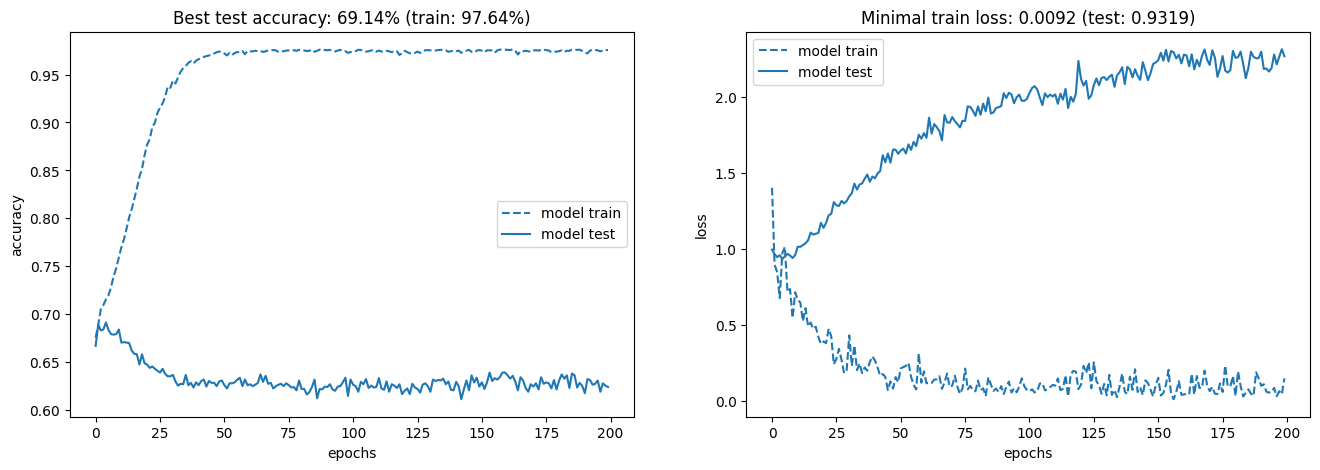

In [16]:
train_size = int(0.8 * len(head_dataset))
test_size = len(head_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(head_dataset, [train_size, test_size])
trainer = HeadTrainer(train_dataset, test_dataset, batch_size=256)
history = trainer.train(model, optimizer, n_epochs=200, loss_fn=torch.nn.CrossEntropyLoss().to(device))
show_results(model=history)